In [104]:
import sys
from qiskit import*
from qiskit import Aer
import qiskit.quantum_info as qi
import numpy as np
import re
#import csv
import time
start = time.time()

In [105]:
N_eps = 300  #int(sys.argv[1])
Target_state = '0000' #sys.argv[2]

In [106]:
# First we note the length of N.
N = len(Target_state)


## The operator U_s.
A = np.ones((2**N, 2**N))
U_s = (2/(2**N))*A - np.identity(2**N, dtype = complex)

In [107]:
U_w = - np.identity(2 ** N, dtype=complex) 
Target_index = int(Target_state, 2)
U_w.itemset((Target_index, Target_index),1)


## G is the Grover operator.
G = np.matmul(U_w, U_s)

In [108]:
l = []

file1 = open('gates_list'+Target_state+'.txt', 'r') # gates_list_000000.txt
Lines = file1.readlines()
 

for line in Lines:
    l.append(line.strip())

gates_list = []

Rz_Number = 0
for i in range(len(l)):
    
    l_temp = []
    gate_name = l[i].split(',')[0]
    if gate_name == 'rz':
        Rz_Number +=1 
    gate_angle = l[i].split(',')[1]
    gate_qubit = l[i].split(',')[2]
    
    l_temp.append(gate_name)
    l_temp.append(gate_angle)
    l_temp.append(gate_qubit)

    gates_list.append(l_temp)

In [109]:
## The dimension of the matrix is fixed by the number of qubits.
def Hadamard(Qubit):
    
    ## Changing the simulator 
    backend = Aer.get_backend('unitary_simulator')

    ## The circuit without measurement
    circ = QuantumCircuit(N)
    circ.h(Qubit)

    ## job execution and getting the result as an object
    job = execute(circ, backend)
    result = job.result()

    ## get the unitary matrix from the result object
    return result.get_unitary(circ)


# ### CNOT gate

# In[40]:


## The dimension of the matrix is fixed by the number of qubits.
def CNOT(t,c):
    ## Changing the simulator 
    backend = Aer.get_backend('unitary_simulator')

    ## The circuit without measurement
    circ = QuantumCircuit(N)
    circ.cx(t,c)

    ## job execution and getting the result as an object
    job = execute(circ, backend)
    result = job.result()

    ## get the unitary matrix from the result object
    return result.get_unitary(circ) 


# ### RZ gate

# In[41]:


def Rz(Angle, Qubit):
    ## Changing the simulator 
    backend = Aer.get_backend('unitary_simulator')

    ## The circuit without measurement
    circ = QuantumCircuit(N)
    circ.rz(Angle, Qubit)

    ## job execution and getting the result as an object
    job = execute(circ, backend)
    result = job.result()

    ## get the unitary matrix from the result object
    return result.get_unitary(circ)     

In [110]:
Rz_Noise = 2*(np.random.rand(Rz_Number)-0.5)

In [111]:
def Grover_reconstructed(epsilon):
    
    ## Initializing the oracle U_w as an identity matrix.
    
    Or = np.identity(2**N, dtype = complex) 

    ## In the following loop we multiply all the 1 and 2 qubit gates with (or without) noise.
    
    j = 0 # Index for the random noise list.
    
    for i in range(len(gates_list)): # l is the list with all the gates.
    
        if gates_list[i][0] == 'rz':
            
            Noise = np.random.rand(1)[0]
            Or = np.matmul(Or, Rz(float(gates_list[i][1])  + epsilon * Rz_Noise[j], int(gates_list[i][2])))
            
            j = j + 1
        
        elif gates_list[i][0] == 'h':
        
            Or = np.matmul(Or, Hadamard(int(gates_list[i][2])))
        
        else:
        
            Or = np.matmul(Or, CNOT(int(gates_list[i][1]), int(gates_list[i][2])))
     
    ## In the following we will fix the phase of the reconstructed Oracle. First we will make all the elements
    # 1 or -1.
    Or = Or/Or[0,0]
    
    ## The sign of the reconstructed Oracle should be same as that of original U_w.
    if np.sign(Or[0,0]) == np.sign(U_w[0,0]):
        
        pass # If the sign is same, then pass.
    
    else:
        
        Or = -Or # Otherwise change the sign.
    Gr = np.matmul(Or, U_s) ## The Grover operator G = U_w * U_s.
    
    return Gr


In [112]:
import numpy
import numpy.linalg

sigma_x=numpy.zeros((2,2),dtype=complex)
sigma_y=numpy.zeros((2,2),dtype=complex)
sigma_z=numpy.zeros((2,2),dtype=complex)
sigma_0=numpy.identity(2,dtype=complex)
sigma_x[0,1]=1.
sigma_x[1,0]=1.
sigma_y[0,1]=-1.j
sigma_y[1,0]=1.j
sigma_z[0,0]=1.
sigma_z[1,1]=-1.
sigma_plus=(sigma_x+1.j*sigma_y)/2.
sigma_minus=(sigma_x-1.j*sigma_y)/2.

def adjoint(psi):
    return psi.conjugate().transpose()

def psi_to_rho(psi):
    return numpy.outer(psi,psi.conjugate())

def exp_val(psi, op):
    return numpy.real(numpy.dot(adjoint(psi),op.dot(psi)))

def norm_sq(psi):
    return numpy.real(numpy.dot(adjoint(psi),psi))

def normalize(psi,tol=1e-9):
    ns=norm_sq(psi)**0.5
    if ns < tol:
        raise ValueError
    return psi/ns

def comm(a,b):
    return a.dot(b)-b.dot(a)

def anti_comm(a,b):
    return a.dot(b)+b.dot(a)

def is_herm(M,tol=1e-9):
    if M.shape[0]!=M.shape[1]:
        return False
    diff=M-adjoint(M)
    return max(numpy.abs(diff.flatten())) < tol

def is_unitary(M,tol=1e-9):
    if M.shape[0]!=M.shape[1]:
        return False
    diff=M.dot(adjoint(M))-numpy.identity((M.shape[0]))
    return max(numpy.abs(diff.flatten())) < tol

def eigu(U,tol=1e-9):
    (E_1,V_1)=numpy.linalg.eigh(U+adjoint(U))
    U_1=adjoint(V_1).dot(U).dot(V_1)
    H_1=adjoint(V_1).dot(U+adjoint(U)).dot(V_1)
    non_diag_lst=[]
    j=0
    while j < U_1.shape[0]:
        k=0
        while k < U_1.shape[0]:
            if j!=k and abs(U_1[j,k]) > tol:
                if j not in non_diag_lst:
                    non_diag_lst.append(j)
                if k not in non_diag_lst:
                    non_diag_lst.append(k)
            k+=1
        j+=1
    if len(non_diag_lst) > 0:
        non_diag_lst=numpy.sort(numpy.array(non_diag_lst))
        U_1_cut=U_1[non_diag_lst,:][:,non_diag_lst]
        (E_2_cut,V_2_cut)=numpy.linalg.eigh(1.j*(U_1_cut-adjoint(U_1_cut)))
        V_2=numpy.identity((U.shape[0]),dtype=V_2_cut.dtype)
        for j in range(len(non_diag_lst)):
            V_2[non_diag_lst[j],non_diag_lst]=V_2_cut[j,:]
        V_1=V_1.dot(V_2)
        U_1=adjoint(V_2).dot(U_1).dot(V_2)

    # Sort by phase
    U_1=numpy.diag(U_1)
    inds=numpy.argsort(numpy.imag(numpy.log(U_1)))

    return (U_1[inds],V_1[:,inds]) # = (U_d,V) s.t. U=V*U_d*V^\dagger


In [113]:
L = N // 2 # Length of half cut number of qubits.

In [114]:


'''
    The following function takes a wavefunction as input and returns its entropy.

'''

def Entropy(Wavefunction):




    # Converting the list to a numpy matrix.
    Psi = np.matrix(Wavefunction).reshape(len(Wavefunction),1) # Psi column matrix.

    # Normalizing Psi.
    Psi = Psi/np.linalg.norm(Psi)


      
    
    def psi(s):
        return Psi[(2**L)*s:(2**L)*s + 2**L]   
    
      
    '''
        psi(s_p) is a row matrix/vector. psi(s) is a column matrix/vector.      
        Dimension of rhoA is N/2 x N/2. 
        The element <s|rhoA|sp> is given by psi_sp^\dagger * psi_s.
        
    ''' 

    def rhoA(s,s_p): # <s|rho_A|s_p>

        # psi(s_p)^\dagger * psi(s) is the element of (s,s_p) of rho_AB.  
        return psi(s_p).getH() * psi(s)
    
    
    
    def rhoA_Matrix(N):
    
        M = np.zeros((N,N), dtype = complex) # 0 to N-1.
    
        '''
            rho is Hermitian, it is sufficient to calculate the elements above the diagonal.
            The the elements below the diagonal can be replace by the complex cpnjugate of the
            elements above the diagonal.
        '''
        for i in range(N):
            for j in range(N):
            
                if i <= j : # Above the diagonal (i,j) i<j.
                
                    M[i,j] = rhoA(i,j)[0,0]
                
                else: # Below the diagonal (i,j) i>j.
                
                    M[i,j] = np.conjugate(M[j,i])
        return M    
    
    
    '''
        w is the diagonal of the diagonalized matrix rhoA.

    '''
    
    w, v = np.linalg.eig(rhoA_Matrix(N))
    
    w = w.real

    '''
        The following loop calculates S = - sum \lamba_i * log(\lambda_i).

    '''
    
    DL = np.zeros(N) # Creating an array for log w with zeros.
    
    for i in range(len(w)):
    
        if abs(w[i]) < 1.e-8: # log of zero gives nan.
        
            pass # Leave the log(zero) element as zero.
    
        else:
        
            DL[i] = np.log(w[i])
        
    # Entropy = -Tr(rho * log(rho)).        
    return -sum(w*DL)

In [115]:
def Phi_F(operator): 
    
    return (1j*np.log(eigu(operator)[0])).real  # eigu(Gr)[0] = exp(-i * phi_F).


In [116]:
def V_Matrix(operator):
    return eigu(operator)[1]

In [117]:
def Arr2List(Arr):
    Arr_l = Arr.tolist()
    l = []
    for i in Arr_l:
        l.append(i[0])
    return l

In [118]:
#f = open('matrix_v'+Target_state+'.txt', 'w')
f = open('phi_F.txt','w')
g = open('entropy_V.txt','w')

In [119]:
for i in range(1,N_eps):

    eps = i/(N_eps)
    #print(eps)
    

#    X = str(eps)
    Y = Phi_F(Grover_reconstructed(eps))
    V = eigu(Grover_reconstructed(eps))[1]

    for m in range(2**N):
        f = open('phi_F.txt','a')
        g = open('entropy_V.txt','a')
        f.write(str(Y[m].real)+'\n')
        g.write(str(   Entropy(Arr2List(V[:,m:m+1]))  )+'\n')
        print('phi', Y[m].real)
        print('Entropy', Entropy(Arr2List(V[:,m:m+1])))
        #for n in range(2**N):

            #f.write(str(V.item((n,m)))+'\n') # entering the columns (n,m).  

phi 2.8250306436207557
Entropy 0.7574624061695789
phi 2.4341323965946637
Entropy 0.7413457068190117
phi 1.4122748704248824
Entropy 1.0576982100293115
phi 1.1774554759271907
Entropy 0.004430407486194754
phi 1.0928045588390245
Entropy 0.596992321003126
phi 0.7914926896375389
Entropy 0.18154778365298804
phi 0.16096258352537354
Entropy 0.716556661623751
phi -0.004066329417563156
Entropy 0.8775112006248638
phi -0.27938761729678513
Entropy 0.38832415910259344
phi -0.4802897881161059
Entropy 0.0008833598730995049
phi -0.7394934186224665
Entropy 0.6444045373114515
phi -1.8408313169354003
Entropy 0.8826978275233366
phi -2.036082387116839
Entropy 0.6325434920742856
phi -2.3417397647687777
Entropy 0.08179442184762695
phi -2.7271496521882836
Entropy 0.8310301297561669
phi -3.1410156498607344
Entropy 1.062929804095436
phi 2.8462071452044686
Entropy 0.7832007451943171
phi 2.442775154324319
Entropy 0.7405299200607408
phi 1.4199419437771115
Entropy 1.0645286436619719
phi 1.1836589711857588
Entropy 0.0

phi 3.0643389767712907
Entropy 1.0463645940399973
phi 2.546220373017517
Entropy 0.7361327447397363
phi 1.5515491931878833
Entropy 1.0966900533031287
phi 1.3197172201953031
Entropy 0.22333884168131873
phi 1.2291139948703607
Entropy 0.20858780868277815
phi 0.9636003571832592
Entropy 0.062233610689032555
phi 0.3966250569204835
Entropy 0.47131753762876316
phi 0.18705276574264806
Entropy 0.6946872128709024
phi 0.06518140971611014
Entropy 0.8099199057837021
phi -0.17430852828428162
Entropy 0.061236749967444146
phi -0.45890472987716685
Entropy 0.6502040396777241
phi -1.7164127721346845
Entropy 1.0819367852756925
phi -2.0562199866046478
Entropy 0.21898105667916085
phi -2.168205898024553
Entropy 0.20418645323826817
phi -2.6414536615652753
Entropy 0.7648070210103888
phi -2.921781980773521
Entropy 0.983039196355683
phi 3.0855504617307434
Entropy 1.0635993471503091
phi 2.5578633305645835
Entropy 0.7360778566537515
phi 1.5699798103294436
Entropy 1.0972512436357251
phi 1.3394953431528318
Entropy 0.2

phi 2.6819316457434503
Entropy 0.7391129520020946
phi 1.7997226192801674
Entropy 1.1085599907331338
phi 1.5778089909042365
Entropy 0.38212341622184215
phi 1.4145374800494812
Entropy 0.10220120950030609
phi 1.2481790088494293
Entropy 0.07344536868871938
phi 0.7369210693439971
Entropy 0.5305046714071264
phi 0.5939629731509338
Entropy 0.7214950726122047
phi 0.27889994323850176
Entropy 0.41180049284032716
phi 0.1494065731700843
Entropy 0.3003476043330715
phi -0.16988225032635915
Entropy 0.6513552740211339
phi -1.471997037645239
Entropy 1.1405145592880304
phi -1.8901172270466309
Entropy 0.4054507183451726
phi -1.9998310822275198
Entropy 0.41945541338222725
phi -2.483506186217451
Entropy 0.7805914558269953
phi -2.592562701074356
Entropy 0.7015766372888037
phi -3.0004982953593493
Entropy 1.0918980230641329
phi 2.6948637778805886
Entropy 0.7396480361466387
phi 1.8266748705925082
Entropy 1.111062742599417
phi 1.6054937803425344
Entropy 0.40420841181673467
phi 1.4356523508898251
Entropy 0.109632

phi 2.8259079444444253
Entropy 0.7425464549815093
phi 2.1260848561505976
Entropy 1.139890556790248
phi 1.9215156057393985
Entropy 0.6574798517600552
phi 1.697749077206856
Entropy 0.4148319667713103
phi 1.6267719618182608
Entropy 0.39158684503658486
phi 1.160810294236422
Entropy 0.7312188954720913
phi 1.0298138690145446
Entropy 0.8427722868893985
phi 0.5681642420904494
Entropy 0.4001444604458058
phi 0.4009548877614053
Entropy 0.45447035191466506
phi 0.11182141395844751
Entropy 0.6469230652014557
phi -1.1537942946960977
Entropy 1.1422369583404681
phi -1.5546110144405934
Entropy 0.4745326956664331
phi -1.8057712567886846
Entropy 0.4827697712727751
phi -2.1621484958552886
Entropy 0.7601549385319958
phi -2.28394336885497
Entropy 0.7666335577410721
phi -2.798133859340043
Entropy 1.0153406092943176
phi 2.8390287761735697
Entropy 0.7422875703503637
phi 2.158528278518212
Entropy 1.1420333251138672
phi 1.9570221744034813
Entropy 0.6841343616734064
phi 1.7301795360674346
Entropy 0.476638162377295

phi 2.969678681706685
Entropy 0.7341780083003068
phi 2.501726842133531
Entropy 1.126296692283673
phi 2.3480840251141224
Entropy 0.9368670058310915
phi 2.1252144306317398
Entropy 0.6238351700339642
phi 2.0461688459864233
Entropy 0.8376338352877287
phi 1.6166349150473347
Entropy 0.807021156257293
phi 1.435030888917476
Entropy 0.8113602499465927
phi 0.9171403910050224
Entropy 0.3836797133231145
phi 0.6205494142707657
Entropy 0.3965949069470423
phi 0.38658787630703323
Entropy 0.6414548399582831
phi -0.7776933373455803
Entropy 1.1193023896975456
phi -1.1704411225718734
Entropy 0.6072139799634207
phi -1.4778080877190634
Entropy 0.6599069599608257
phi -1.7267436932260816
Entropy 0.9151841170833035
phi -2.0196518327445405
Entropy 0.6433148122204009
phi -2.57189931543938
Entropy 0.9577538577179304
phi 2.9828474885011538
Entropy 0.7333304772813477
phi 2.537729024131221
Entropy 1.1177881438093504
phi 2.390440009525946
Entropy 0.9585919727502824
phi 2.169811992707731
Entropy 0.6072748822022447
phi

phi 3.1259760557485134
Entropy 0.7466863882745893
phi 2.915909066899145
Entropy 0.8269354127050319
phi 2.8362675698574074
Entropy 1.037583404743408
phi 2.632689196615555
Entropy 0.5413845903083765
phi 2.4859612796124844
Entropy 0.9211572008290708
phi 2.0549973648608844
Entropy 0.8574734405574174
phi 1.815536805572078
Entropy 0.9161190138885349
phi 1.2692492083049094
Entropy 0.4059833716081561
phi 0.8562324608610353
Entropy 0.39727602499347786
phi 0.6557259575034576
Entropy 0.6366723834353958
phi -0.359833761753078
Entropy 1.0877742432010213
phi -0.7550605072168296
Entropy 0.6839128237670521
phi -1.0258047433324144
Entropy 0.7226913167210481
phi -1.3215171719314274
Entropy 1.0527655952418176
phi -1.7322282852149369
Entropy 0.5585791280264534
phi -2.2986950419347307
Entropy 0.9071585118052946
phi 2.955971020917254
Entropy 0.7653609710072925
phi 2.882147168995219
Entropy 1.014981756068677
phi 2.6787038609030676
Entropy 0.550268556780575
phi 2.524626631599436
Entropy 0.92753149840429
phi 2

phi 3.08257292950543
Entropy 0.8913745139904731
phi 2.8669127395788636
Entropy 0.7743005790931549
phi 2.479164637990228
Entropy 0.7986754400900795
phi 2.1661927649783523
Entropy 1.004257578318629
phi 1.6128885337990277
Entropy 0.44180969953312355
phi 1.1054189907484784
Entropy 0.44055551040704805
phi 0.9151625249434722
Entropy 0.6361034265616389
phi 0.0802032824183243
Entropy 1.0563439430361279
phi -0.316402956069989
Entropy 0.6810326879702233
phi -0.5372064570223726
Entropy 0.794707933473792
phi -0.9383405427647209
Entropy 1.0269639005562103
phi -1.4427647588027992
Entropy 0.4415177712784227
phi -1.9840190849473873
Entropy 0.8543310382567258
phi -2.858446356859407
Entropy 0.8967518096773684
phi -2.929298319757973
Entropy 1.130821730697124
phi -2.9464768767788536
Entropy 0.8690667168193924
phi 3.114998717755256
Entropy 0.9213617147074159
phi 2.8951797742239394
Entropy 0.7272249317303281
phi 2.5166384741024075
Entropy 0.7908841548597566
phi 2.1965292252545416
Entropy 1.0100102243451379


phi 3.120593505844613
Entropy 0.36222211655222614
phi 2.871137802445202
Entropy 0.7291192984785688
phi 2.484471600729463
Entropy 1.0488597123280203
phi 1.9399357733438498
Entropy 0.5019878204820308
phi 1.3636657123717202
Entropy 0.4954041151101501
phi 1.160544298138789
Entropy 0.6458331099101151
phi 0.5257944313208864
Entropy 1.0156273853303222
phi 0.1428963110288165
Entropy 0.6253629523401169
phi -0.09766000980217149
Entropy 0.8235481994786253
phi -0.5638514694238226
Entropy 0.9231722683972982
phi -1.172875418976961
Entropy 0.3083404805825864
phi -1.641310402139925
Entropy 0.8181704654320189
phi -2.3384312363174353
Entropy 0.84663201096987
phi -2.4191054283286557
Entropy 0.8563648477511454
phi -2.524899551155427
Entropy 0.9988558682343265
phi -2.8814673829249515
Entropy 0.8157474892211186
phi 3.1400786517086074
Entropy 0.393117691957324
phi 2.903504425964218
Entropy 0.7283081349153361
phi 2.5116043306723963
Entropy 1.0509562711441407
phi 1.9686082566173584
Entropy 0.5092035271083384
p

phi 2.7639140158242963
Entropy 1.05070638742913
phi 2.2439693305888593
Entropy 0.5996704106192489
phi 1.6399507172743677
Entropy 0.5420962447724099
phi 1.3929292573312635
Entropy 0.6689970473455215
phi 0.9633598166292457
Entropy 0.9194359567148949
phi 0.5872253842817223
Entropy 0.6945591324122564
phi 0.27030455168925094
Entropy 0.7510854160434319
phi -0.19750175946831344
Entropy 0.7982932764427273
phi -0.9351803937618213
Entropy 0.19528690116155553
phi -1.2720315843196275
Entropy 0.7992964780533964
phi -1.8246952979790558
Entropy 0.8231158171538654
phi -1.9095185602472928
Entropy 0.9765845820772218
phi -2.110550268221343
Entropy 0.9077390733806794
phi -2.5882106959543756
Entropy 0.6867333769078814
phi -2.915626952378912
Entropy 0.9233660311016575
phi -3.116072615090063
Entropy 0.760059308853483
phi 2.7871395025081447
Entropy 1.0478322481854037
phi 2.2702839298733393
Entropy 0.6104167166009733
phi 1.6668739879323888
Entropy 0.5447500923186275
phi 1.41360711144603
Entropy 0.6718660981028

phi 3.0006440559600605
Entropy 0.9671505102615668
phi 2.5196823382750795
Entropy 0.7235951132654629
phi 1.9648702690348532
Entropy 0.5420486724616602
phi 1.618664615664163
Entropy 0.70660706417559
phi 1.363180851596447
Entropy 0.7582354833874678
phi 0.9778892400747824
Entropy 0.7357301912897504
phi 0.5742677485879919
Entropy 0.6880963943120137
phi 0.1606150303065492
Entropy 0.7236601403296228
phi -0.7301411889912469
Entropy 0.16634581393181486
phi -0.8690143139698631
Entropy 0.7237444314382321
phi -1.3468009294905623
Entropy 0.7937604538503181
phi -1.4409851936279778
Entropy 0.9309696087392463
phi -1.7420009102375753
Entropy 0.7944290858532673
phi -2.312780816676258
Entropy 0.7107114776308732
phi -2.5930296355218814
Entropy 0.9432551409465568
phi -2.9110110376248044
Entropy 0.8480345030698484
phi 3.0204858742210554
Entropy 0.9526934620962296
phi 2.5431680203454854
Entropy 0.7341413007102848
phi 1.9980875114993493
Entropy 0.5388648892598559
phi 1.6391218352769654
Entropy 0.7105222719368

phi 2.7633402631817177
Entropy 0.7989345135090162
phi 2.36379369318921
Entropy 0.5111167881722133
phi 1.8447555442297643
Entropy 0.748060014705328
phi 1.6910750526566216
Entropy 0.6190715336113439
phi 1.3093398498007227
Entropy 0.7330759474208932
phi 0.8204978485044823
Entropy 0.6810571196986673
phi 0.5077291049065609
Entropy 0.7553741794492478
phi -0.4308771480244135
Entropy 0.729474302551068
phi -0.5564413596076518
Entropy 0.19767144557448102
phi -0.9097392120937638
Entropy 0.751805274466738
phi -1.0171257714424755
Entropy 0.7434322494950535
phi -1.430834471510731
Entropy 0.7264365083064508
phi -2.049200043310359
Entropy 0.8048303410497433
phi -2.267621003989387
Entropy 0.9106660346948412
phi -2.6965683235728157
Entropy 0.9814959061515764
phi -3.068593707051731
Entropy 0.7502128717725449
phi 2.7840451720849746
Entropy 0.7996366964983739
phi 2.4030192143840985
Entropy 0.5122803241913523
phi 1.8654670465095278
Entropy 0.7511859270401495
phi 1.7174726256067732
Entropy 0.6116549049034969

phi 2.9887988164988175
Entropy 0.7508698221925798
phi 2.800158439191852
Entropy 0.6893375153983042
phi 2.074079248255304
Entropy 0.7698538533049621
phi 1.9612448394505433
Entropy 0.5917564237026974
phi 1.5915375681289936
Entropy 0.7297421995921272
phi 1.0315067754041256
Entropy 0.7727171018666088
phi 0.8272288367817322
Entropy 0.8066767355976878
phi 0.007947997768371092
Entropy 0.5499906839589987
phi -0.38284341298413294
Entropy 0.43453793558347587
phi -0.5179752884627097
Entropy 0.715002699988164
phi -0.633569671282605
Entropy 0.5695264514596418
phi -1.167720424926473
Entropy 0.736800006492855
phi -1.7872859511882793
Entropy 0.9331563490205477
phi -1.9562657817946556
Entropy 0.9249985453916788
phi -2.4650840099964384
Entropy 1.050797811259714
phi -2.8429738400615068
Entropy 0.4891674220484996
phi 3.0108831849389883
Entropy 0.7404089904432477
phi 2.838054047529134
Entropy 0.7388119234590019
phi 2.0950662574849686
Entropy 0.7703746875248395
phi 1.9841718659060892
Entropy 0.5941636779720

phi 3.123899754856512
Entropy 0.9127310655155499
phi 2.3058232267826226
Entropy 0.7676135478235454
phi 2.206237709037313
Entropy 0.6317958949657846
phi 1.8378443774324544
Entropy 0.7398549391468666
phi 1.2776772228449447
Entropy 0.6877197654082097
phi 1.0667155631820429
Entropy 0.6227227215338874
phi 0.4240913229082696
Entropy 0.4421310067631457
phi -0.11335670298138374
Entropy 0.869247110960109
phi -0.22319983407302102
Entropy 0.8834446627672212
phi -0.3211714616905659
Entropy 0.747337530163815
phi -0.9359717703311552
Entropy 0.7949784294748353
phi -1.513840358413805
Entropy 1.0012566873784483
phi -1.6627809072912363
Entropy 0.9504103142785687
phi -2.225062468843113
Entropy 1.0814457483934385
phi -2.5940040927811
Entropy 0.3177507194017251
phi -2.966047197645784
Entropy 0.39721302929689734
phi 2.3269884514355055
Entropy 0.7672775699079292
phi 2.2280121986616725
Entropy 0.6358542427469376
phi 1.8589615391893317
Entropy 0.7415547580178058
phi 1.3033583684095438
Entropy 0.675666490929817

phi 2.5403806367625617
Entropy 0.7802600418535681
phi 2.444970487630745
Entropy 0.6716832554522162
phi 2.063274629475323
Entropy 0.7621145692941892
phi 1.5702163381967917
Entropy 0.703966438119831
phi 1.2603651491243084
Entropy 0.5642339109571517
phi 0.7664192047018693
Entropy 0.33855903269734444
phi 0.22770375264838785
Entropy 0.6519920466730296
phi 0.07400128320219615
Entropy 0.4649708163420928
phi -0.1328877361989332
Entropy 0.6154785952189785
phi -0.7201650227145829
Entropy 0.8559675683349326
phi -1.2121915971977433
Entropy 0.8730134010374835
phi -1.3943846187122133
Entropy 0.9004264907850242
phi -1.9756371338383933
Entropy 1.0860573750961684
phi -2.3270738754722955
Entropy 0.28008401910267794
phi -2.5525887228143995
Entropy 0.23430979480459038
phi -2.9486602891839526
Entropy 0.6851746305514688
phi 2.5620064794274797
Entropy 0.7838912560624558
phi 2.466711990936874
Entropy 0.6745505114378889
phi 2.0833017348076424
Entropy 0.76410073716435
phi 1.597097519976083
Entropy 0.71270552405

phi 2.784431958269818
Entropy 0.8333292862398048
phi 2.6851807876251206
Entropy 0.6885438637034731
phi 2.284780172984626
Entropy 0.7738742921151238
phi 1.8632563048727262
Entropy 0.7891967991038062
phi 1.5120725621991793
Entropy 0.5981631833249891
phi 0.9767251099539094
Entropy 0.24880867499715242
phi 0.5626158140118103
Entropy 0.5871728252448785
phi 0.3638675053736334
Entropy 0.3521355859438121
phi 0.04364942671825391
Entropy 0.6187293417412726
phi -0.5035536897111599
Entropy 0.8845171835685153
phi -0.8773750946096454
Entropy 0.7434744794184678
phi -1.1521776381712272
Entropy 0.7979813759657945
phi -1.7100549632689295
Entropy 1.054184602872903
phi -2.0466784921183976
Entropy 0.3485581255029535
phi -2.1826846522477124
Entropy 0.2528170900357172
phi -2.7411766533830186
Entropy 0.5472630268072186
phi 2.807536018049892
Entropy 0.8374260704927549
phi 2.707076010739303
Entropy 0.6878371698458317
phi 2.305361282485357
Entropy 0.773385931221135
phi 1.8896985179549732
Entropy 0.794703537682956

phi 3.0506292499772876
Entropy 0.8359245027487069
phi 2.924984025777915
Entropy 0.658031786404525
phi 2.520818185125692
Entropy 0.7524045289805974
phi 2.156100956851013
Entropy 0.8033925631450621
phi 1.7861501823654518
Entropy 0.6809977959781293
phi 1.098263080209878
Entropy 0.3031622433970609
phi 0.8871265589687047
Entropy 0.6065024140445376
phi 0.6374704877284234
Entropy 0.3581922695502453
phi 0.24680060167340293
Entropy 0.6274541536452332
phi -0.24953251970486565
Entropy 0.8586915007810938
phi -0.5350730193348697
Entropy 0.7034274069570352
phi -0.9317232121144465
Entropy 0.6944944553275045
phi -1.4288517055559997
Entropy 0.9988001244932081
phi -1.755101936101483
Entropy 0.44305144865878926
phi -1.8725845949143387
Entropy 0.4028489302396937
phi -2.524106732833434
Entropy 0.4483936126277369
phi 3.076190144186382
Entropy 0.831787214195242
phi 2.946618184645857
Entropy 0.6536606070743992
phi 2.5435929550303085
Entropy 0.749077493200317
phi 2.183061673859686
Entropy 0.7985950859916022
ph

phi 2.786167988822442
Entropy 0.7149523939707397
phi 2.453168395347633
Entropy 0.7148345171959001
phi 2.0162367855889682
Entropy 0.7218967625935999
phi 1.2462840125202534
Entropy 0.7649145334899495
phi 1.1566411975101039
Entropy 0.6912336467634198
phi 0.9050165681307909
Entropy 0.38973742059063504
phi 0.4866103812754104
Entropy 0.6390972063818763
phi 0.103841804061256
Entropy 0.6490245744465779
phi -0.24351414595596924
Entropy 0.6244623728053234
phi -0.731126784115294
Entropy 0.5895982453509397
phi -1.1481261252587303
Entropy 0.963185398766065
phi -1.4620778095723583
Entropy 0.48873050583647804
phi -1.5985126824561742
Entropy 0.5264156351758583
phi -2.293494652130591
Entropy 0.382388268291563
phi -2.9416703502976036
Entropy 0.7838844738112748
phi -3.121986358698478
Entropy 0.6150396793417776
phi 2.811849517326763
Entropy 0.7121020897562654
phi 2.4798826249228543
Entropy 0.7055031361369848
phi 2.0345285519523926
Entropy 0.7223806515795885
phi 1.2694649217161476
Entropy 0.744278143906343

phi 3.0771093396440383
Entropy 0.6951955411753128
phi 2.739104285685232
Entropy 0.6391277157113194
phi 2.1972086709680227
Entropy 0.7085750457609494
phi 1.5325101614333778
Entropy 0.6003682357963127
phi 1.2880323849575799
Entropy 0.48361891662641987
phi 1.1713826203003412
Entropy 0.4011543504476283
phi 0.7647992309680883
Entropy 0.7436471316010731
phi 0.5223898295832284
Entropy 0.6432762695730632
phi 0.013205642398826769
Entropy 0.5719538915766148
phi -0.5484497763029066
Entropy 0.5352530256058368
phi -0.8913476223191124
Entropy 0.9519204842479467
phi -1.1803485521739259
Entropy 0.5653902100592442
phi -1.3368324012645738
Entropy 0.610765405972787
phi -2.046560915238947
Entropy 0.3580712040053371
phi -2.6447320663018323
Entropy 0.7721385335734565
phi -2.8917953383510966
Entropy 0.6005721761441067
phi 3.1039274060994058
Entropy 0.6946688245921545
phi 2.764096328531678
Entropy 0.6359702412062247
phi 2.2116482810988325
Entropy 0.7060649388708643
phi 1.559003097679944
Entropy 0.597550070985

phi 3.0038293987764684
Entropy 0.6366917687771653
phi 2.339921832133933
Entropy 0.676321494967581
phi 1.8123879112408317
Entropy 0.5889746866992276
phi 1.4863119686294521
Entropy 0.8688475756622112
phi 1.37947276791333
Entropy 0.5527500600923938
phi 1.103948302115899
Entropy 0.668200193094872
phi 0.8909073967235359
Entropy 0.7010152507175761
phi 0.2734419053799771
Entropy 0.5822051202212599
phi -0.37149691012880137
Entropy 0.6258566511139169
phi -0.6882210043888972
Entropy 0.9357863707786922
phi -0.9253459300626233
Entropy 0.7581502859879178
phi -1.081793566183247
Entropy 0.7151559929988661
phi -1.7831946486163328
Entropy 0.38023881220896966
phi -2.3723065106863843
Entropy 0.8061510019240814
phi -2.6768598283114295
Entropy 0.6112079210822463
phi -2.9184637306047057
Entropy 0.6989232457287002
phi 3.0267543399731354
Entropy 0.6394590645234142
phi 2.351218971250666
Entropy 0.6729836355772282
phi 1.8362837144592992
Entropy 0.5885298948392953
phi 1.5113801238139732
Entropy 0.858343839884641

phi 2.4506035634733188
Entropy 0.6363618324601531
phi 2.0581145228996984
Entropy 0.5786695307775286
phi 1.788908367347296
Entropy 0.7550963836981898
phi 1.553730094360782
Entropy 0.9689157822187275
phi 1.451763797210391
Entropy 0.7138275524250154
phi 1.154235516511137
Entropy 0.5539990818623648
phi 0.5391654631399876
Entropy 0.6066642019950261
phi -0.18688996349735687
Entropy 0.7668916548957481
phi -0.5490086387821675
Entropy 0.9032610688612228
phi -0.7136759188544473
Entropy 1.0739014995913094
phi -0.8414524912981454
Entropy 0.9129424752905967
phi -1.5103672817141098
Entropy 0.4285453012104353
phi -2.1470526389841074
Entropy 0.829480668074118
phi -2.4894112092319918
Entropy 0.6334365261332067
phi -2.6629362913175116
Entropy 0.7233166006745073
phi -3.0385970444852264
Entropy 0.6839402428468873
phi 2.4593332478318817
Entropy 0.6324980807759901
phi 2.0785370763694235
Entropy 0.5773660815619753
phi 1.8190764260161028
Entropy 0.7400832512911849
phi 1.5772725474475946
Entropy 1.001894666492

phi 2.5391730257647187
Entropy 0.6099056231836298
phi 2.2658590288311746
Entropy 0.6039367216333855
phi 2.1406415813032607
Entropy 0.5281097263684877
phi 1.846786778936848
Entropy 0.9933702808118028
phi 1.629082393542015
Entropy 0.5743879178673252
phi 1.3593202054683011
Entropy 0.5261769379447928
phi 0.800524606479151
Entropy 0.6186229770223546
phi -0.006126254309450972
Entropy 0.8401127377747157
phi -0.40699710759116003
Entropy 0.8401396087576932
phi -0.5423990734786455
Entropy 0.680295457692404
phi -0.6696614776017663
Entropy 1.062927322004261
phi -1.2453936549341675
Entropy 0.475331607071007
phi -1.9678989486960123
Entropy 0.8079006893338182
phi -2.335868280730714
Entropy 0.6625839014191509
phi -2.449351334062097
Entropy 0.7676604408955976
phi -2.8268312243497085
Entropy 0.7435561536749845
phi 2.546897903907692
Entropy 0.6137591581230967
phi 2.283070864777951
Entropy 0.6203787454489256
phi 2.173799366612323
Entropy 0.5133576636260627
phi 1.8725810845890918
Entropy 0.9857497595324585

phi 2.6458826028198215
Entropy 0.9041968421928441
phi 2.498883086924528
Entropy 0.7597285172840258
phi 2.4248122614359504
Entropy 0.7305174145732961
phi 2.1056043264071067
Entropy 0.9048107548862807
phi 1.7772936965018309
Entropy 0.585507120597919
phi 1.5351937054172453
Entropy 0.5711150727300145
phi 1.045807505368287
Entropy 0.6245677452910215
phi 0.15741963757308322
Entropy 0.8903503574850945
phi -0.21385399556349338
Entropy 0.7448468652281003
phi -0.35230244361078084
Entropy 1.0270779616858396
phi -0.6354143175350021
Entropy 0.818545478119832
phi -1.0089515309499166
Entropy 0.5012468183470569
phi -1.816911945240218
Entropy 0.7433880725080084
phi -2.2034207622376165
Entropy 0.6186367103020319
phi -2.283710415629627
Entropy 0.6818764223459686
phi -2.652391946620393
Entropy 0.7725543191435393
phi 2.661988512616275
Entropy 0.9401333217548629
phi 2.52451450494288
Entropy 0.8071396921559786
phi 2.4379305698282963
Entropy 0.7444546560482009
phi 2.1264402448000967
Entropy 0.9014004313823754

phi 2.920309187548322
Entropy 0.4854864980899388
phi 2.7036097913607913
Entropy 0.8673832002408242
phi 2.5313762453252555
Entropy 0.8342580095947211
phi 2.309872591031244
Entropy 0.952091472024569
phi 1.924769848896488
Entropy 0.649552085314616
phi 1.7006424006680803
Entropy 0.6483090955459304
phi 1.2626530703906764
Entropy 0.6384635193635879
phi 0.30476394688674463
Entropy 0.9504498887305864
phi 0.009765537701164409
Entropy 0.5575342973478881
phi -0.1779411760226829
Entropy 0.9806432126432023
phi -0.6521155279659875
Entropy 0.7725594285619724
phi -0.8183258476267637
Entropy 0.54576188863639
phi -1.6724939971827504
Entropy 0.6888060073667768
phi -2.05631669186789
Entropy 0.5138612519916879
phi -2.1875646903011914
Entropy 0.46969181133537136
phi -2.52161773214968
Entropy 0.7524029295845557
phi 2.9498111159300695
Entropy 0.4533183911925457
phi 2.71925907737087
Entropy 0.8585551544295978
phi 2.5375475414378728
Entropy 0.8258574541845073
phi 2.3257311062929933
Entropy 0.9611205242446873
ph

phi 2.8863605643598906
Entropy 0.8295262496956518
phi 2.5818866470048074
Entropy 0.677865300520722
phi 2.4622736877286187
Entropy 1.014190547250374
phi 2.069258853623665
Entropy 0.7477710912811621
phi 1.8586720301358917
Entropy 0.7010644572521643
phi 1.441931534461284
Entropy 0.668848010940885
phi 0.4486563651264718
Entropy 0.9923135066735649
phi 0.23798900087814287
Entropy 0.40874722523233903
phi -0.028606366641189585
Entropy 0.9197808895495007
phi -0.6227122884184386
Entropy 0.6947842321320039
phi -0.7295882803460261
Entropy 0.6750284638092922
phi -1.5169234321070435
Entropy 0.7280816273317345
phi -1.9085473538846975
Entropy 0.5412325158901944
phi -2.1373131384427264
Entropy 0.42143191531140706
phi -2.4309648444378484
Entropy 0.7233207121277436
phi -3.0512820322874377
Entropy 0.32974459876329776
phi 2.903988682899136
Entropy 0.8285571517135428
phi 2.5852815358202097
Entropy 0.6609758686036518
phi 2.4740212460904027
Entropy 1.0144998091180268
phi 2.082052325848731
Entropy 0.7562348189

phi 3.0846524037069547
Entropy 0.8103756979352181
phi 2.6239073906567225
Entropy 0.6231349050385382
phi 2.57203836095034
Entropy 0.9135461125466318
phi 2.203390934646851
Entropy 0.8059525972028839
phi 1.9930763416816406
Entropy 0.7136322883642032
phi 1.581473193507701
Entropy 0.7180834253939311
phi 0.609614913841953
Entropy 0.9676527589702173
phi 0.44615033130230564
Entropy 0.4465350827847486
phi 0.09061634167223057
Entropy 0.9188751678790135
phi -0.5148172091736644
Entropy 0.4186395019774033
phi -0.7474868814619549
Entropy 0.6559123234419175
phi -1.3440212457959775
Entropy 0.8200657308705086
phi -1.7732334079410157
Entropy 0.5710373734538621
phi -2.110720808303372
Entropy 0.43135716519767936
phi -2.3679478776053395
Entropy 0.7312404684243251
phi -2.7918370757577935
Entropy 0.3996483342686089
phi 3.1029262289263095
Entropy 0.807864248584166
phi 2.6302374943212747
Entropy 0.6768939186575864
phi 2.5785725705802633
Entropy 0.8832582444914948
phi 2.214629752474588
Entropy 0.806812499067511

phi 2.727828940375502
Entropy 0.9246340119173743
phi 2.6093767279000053
Entropy 0.7836207873096015
phi 2.3154637382266228
Entropy 0.8051108544459582
phi 2.0822525249414516
Entropy 0.6959462776761561
phi 1.6807589084695862
Entropy 0.7833843408314276
phi 0.7986673352897424
Entropy 0.8777242637840745
phi 0.6162887844335178
Entropy 0.6647217405264834
phi 0.17808176867757303
Entropy 0.9498733383844384
phi -0.417493950637241
Entropy 0.34094813098742505
phi -0.7571225031296379
Entropy 0.7042876956417086
phi -1.1618185126545604
Entropy 0.9108354599228652
phi -1.6500016186833912
Entropy 0.6143491465452726
phi -2.0958223055553704
Entropy 0.5195736804581541
phi -2.320795322961107
Entropy 0.7758710232733891
phi -2.602419235950021
Entropy 0.5628897766636283
phi -2.998219105639476
Entropy 0.7861787901888293
phi 2.7393179891580965
Entropy 0.9293971258412882
phi 2.610859306379215
Entropy 0.7852043254306834
phi 2.3244105722930333
Entropy 0.805255631894164
phi 2.0875828598023545
Entropy 0.69532689789072

phi 2.858084661268993
Entropy 0.9460242557874793
phi 2.6218169822545496
Entropy 0.8366823865534834
phi 2.4047776158216756
Entropy 0.7701282794088633
phi 2.115078016399402
Entropy 0.7298362147378843
phi 1.7340035003549128
Entropy 0.8521256276945629
phi 0.9959803010291778
Entropy 0.7568381014158042
phi 0.7534692488574894
Entropy 0.7741228848487509
phi 0.239967940645683
Entropy 0.9803536581868946
phi -0.333002325890111
Entropy 0.3358679428879141
phi -0.7285487181066675
Entropy 0.766166014681876
phi -0.9918116804386693
Entropy 1.0027362006750913
phi -1.5448622198669129
Entropy 0.7244813075965104
phi -2.078117821523655
Entropy 0.6818726527483338
phi -2.2881099395423288
Entropy 0.8113675824407705
phi -2.4835322512293825
Entropy 0.7006042147363601
phi -2.803111684981656
Entropy 0.7921108461749982
phi 2.8699417086735095
Entropy 0.9454960085532997
phi 2.6227456194411936
Entropy 0.8421723293263272
phi 2.412021203400006
Entropy 0.7623043158460385
phi 2.1154567014501002
Entropy 0.7381548768831325


phi 2.983012839296139
Entropy 0.9265791698567563
phi 2.6332530340796754
Entropy 0.8540613324622125
phi 2.476512388085266
Entropy 0.6344276904152697
phi 2.1020532868889226
Entropy 0.8551964578899867
phi 1.7315129600958776
Entropy 0.8927028884880628
phi 1.178479362993091
Entropy 0.670485555470322
phi 0.8624579433767198
Entropy 0.8222116856099239
phi 0.2829948667482214
Entropy 0.9884739964023745
phi -0.2558707851222506
Entropy 0.3999938207439912
phi -0.6312954159064122
Entropy 0.7869444484654127
phi -0.8758035144492582
Entropy 0.9898997928782387
phi -1.4696329363039518
Entropy 0.8597440426168678
phi -2.042972605459752
Entropy 0.8075336722807283
phi -2.2690086182715956
Entropy 0.8558676934386252
phi -2.428253920505779
Entropy 0.7342405636322648
phi -2.6207475584851623
Entropy 0.8537151636769745
phi 2.993574735513987
Entropy 0.9238820615316068
phi 2.634605064000856
Entropy 0.8492474296391421
phi 2.4820452472848635
Entropy 0.6164170947902798
phi 2.099418005165964
Entropy 0.8679802146832759
p

In [120]:
#print('Done')
end = time.time()
print('Time taken', (end-start)/60,'minutes')

Time taken 20.06599679787954 minutes


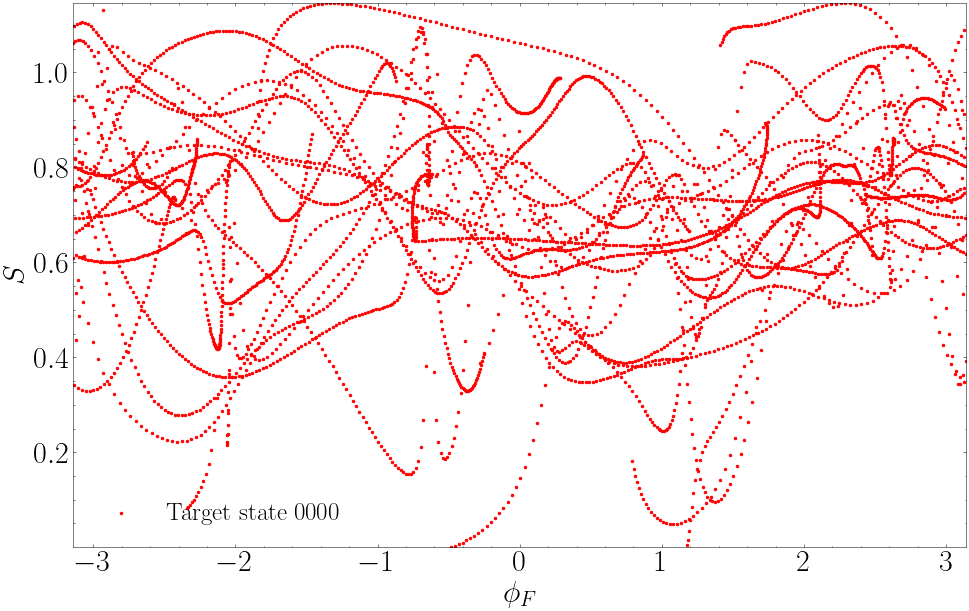

In [126]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 30})

X = np.loadtxt('phi_F.txt', delimiter = ',', unpack=True)
Y = np.loadtxt('entropy_V.txt', delimiter = ',', unpack=True)

pparam = dict(xlabel='$\phi_F$', ylabel='$S$')

#x = np.linspace(0.75, 1.25, 201)
label = 'Target state 0000'
with plt.style.context(['science' ]):

    fig, ax = plt.subplots(figsize=(16, 10))
    #ax.plot(X, Y, label='Phi vs epsilon')
    ax.scatter(X, Y,s=6, c='r', marker ='o',label= label)
    ax.legend(loc='best', prop={'size': 25})
    ax.autoscale(tight=True)
    ax.set(**pparam)
    plt.show()
    #fig.savefig(data_set+'.pdf')
    fig.savefig('fig1.jpg', dpi=600)